In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import difflib

## Notebook to annotate HLS speeches for principles
### B: string-based labels

Codebooks:
- B2.0: zero shot
- B2.1: one shot

Only apply on sentences in OG dataframe labelled as relevant
Temperature: 0
Iterations: 1

Model selection:
 As of 22-05-2024, gpt-4-turbo-2024-04-09 seems to be the only gpt-model that returns a fingerprint in addition to gpt-4o

  #model= "gpt-4-turbo-2024-04-09"
  #model = "gpt-3.5-turbo-0125"


### 1. Import text to annotate
Select only relevant columns of the full dataframe, in this case:
PRINCIPLE

In this case, evaluation is performed on only the sentences that are deemed relevant in the manual annotation. Only these sentences are labelled for the principle they present.

In [2]:
# Import string based datafile
HLS_train = pd.read_csv('data/string/HLS_train_string.csv')

In [3]:
### Select only japan for testing purposes
#HLS_train_japan = HLS_train[HLS_train['id']=='COP19_japan']
HLS_train_relevant = HLS_train[HLS_train['RELEVANCE']=='Relevant']

In [4]:
# Select only columns containing relevance labels
HLS_principle = HLS_train_relevant[['Text', 'PRINCIPLE']]
HLS_principle

,Text,PRINCIPLE
3,Mr. President: A fair and effective framewor...,utilitarian
5,Such a framework must be based on “nationally ...,egalitarian
44,It should not only enable us to discuss global...,utilitarian
53,Global warming is a catastrophic problem that ...,utilitarian
54,"Therefore, the multilateralism approach remain...",general normative statement
...,...,...
1172,As we work to catch up on lost time and progr...,prioritarian
1173,"Conflict -ridden communities, refugees, and d...",prioritarian
1174,"Nor can we stand by , as the massive destructi...",utilitarian
1198,We recognise that we must deliver on our coll...,prioritarian


In [5]:
HLS_principle.PRINCIPLE.value_counts()

prioritarian                   66
utilitarian                    59
egalitarian                    51
general normative statement    33
sufficientarian                 8
libertarian                     1
Name: PRINCIPLE, dtype: int64

### 2. Import necessary files
- codebooks
- API key
- import gpt_annotate_num

In [6]:
# Load codebook - zero shot
with open('codebooks/B2.0', 'r', encoding='utf-8') as file:
    B20 = file.read()

In [7]:
# OpenAI key
with open('gpt_api_key.txt', 'r') as f:
    key = f.read().strip()

In [8]:
import gpt_annotate_string

### 3. Prepare data for annotation
Compares column names in HLS_principle to the codes identified by GPT-4o in the codebook. Seed for this identification is set to 1234.

In [9]:
# Prepare dataframe for annotation
text_to_annotate = gpt_annotate_string.prepare_data(HLS_principle, B20, key, prep_codebook=True)

ChatCompletion(id='chatcmpl-9X4n4012lUNhn8thU5wR7f6y2jIUE', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='PRINCIPLE', role='assistant', function_call=None, tool_calls=None))], created=1717670266, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_319be4768e', usage=CompletionUsage(completion_tokens=3, prompt_tokens=582, total_tokens=585))

Categories to annotate:
1) PRINCIPLE


Data is ready to be annotated using gpt_annotate()!

Glimpse of your data:
Shape of data:  (218, 4)
   unique_id                                               text  \
0          3   Mr. President:  A fair and effective framewor...   
1          5  Such a framework must be based on “nationally ...   
2         44  It should not only enable us to discuss global...   
3         53  Global warming is a catastrophic problem that ...   
4         54  Therefore, the multilateralism approach remain...   

                     PRINCIPLE  \
0 

Fingerprint used: fp_43dfabdef1 (OG - only 138 selected))
Fingerprint used: fp_319be4768e

Seed of textpreparation is hardcoded into gpt_annotate. This to ensure that onlye the results of the same fingerprint for all seeds and all iterations. Essentially every time GPT-4o is called only results with this specific fingerprint are saved.

# 4. Run gpt_annotate_num
Evaluation per seed -
5 different seeds
Batch of 20 sentences
1 iteration

Returns 3 outputs:
1. all_iterations_{seed}.csv
2. fingerprints_all.csv
3. missed_batches.csv

## B2.0 principle - zero shot

In [10]:
#fingerprint = 'fp_43dfabdef1' OG!
fingerprint = 'fp_319be4768e'

#Block seed to prevent accidental rerun of gpt_annotate
seeds = [3644,3441, 280, 5991, 7917]

In [15]:
# Annotate the data - T0 - I1
for seed in seeds:
    gpt_annotate_string.gpt_annotate(text_to_annotate, B20, key, seed,fingerprint, experiment="B2.0",  num_iterations=1, model="gpt-4o", temperature=0, batch_size=20, human_labels=True)

3644 - iteration 1
iteration:  1 completed
3441 - iteration 1
3441 - I1 - B8 fingerprint does not match
iteration:  1 completed
280 - iteration 1
280 - I1 - B1 fingerprint does not match
280 - I1 - B11 fingerprint does not match
iteration:  1 completed
5991 - iteration 1
iteration:  1 completed
7917 - iteration 1
iteration:  1 completed


## B2.1 principle - one shot

In [12]:
# Load codebook - zero shot
with open('codebooks/B2.1', 'r', encoding='utf-8') as file:
    B21 = file.read()

In [13]:
# Annotate the data - T0 - I1
for seed in seeds:
    gpt_annotate_string.gpt_annotate(text_to_annotate, B21, key, seed,fingerprint, experiment="B2.1",  num_iterations=1, model="gpt-4o", temperature=0, batch_size=20, human_labels=True)

3644 - iteration 1
iteration:  1 completed
3441 - iteration 1
iteration:  1 completed
280 - iteration 1
iteration:  1 completed
5991 - iteration 1
iteration:  1 completed
7917 - iteration 1
iteration:  1 completed


### 5. Define evaluation functions


In [18]:
# Define similarity score function and save to DF
def get_similarity_score(Rx, Ry):
    # Ensure Rx and Ry are pandas Series and convert to strings with stripped whitespace
    Rx = Rx.astype(str).str.strip()
    Ry = Ry.astype(str).str.strip()

    # Calculate similarity scores
    similarity_scores = Rx.combine(Ry, lambda x, y: difflib.SequenceMatcher(None, x, y).ratio())

    # Apply the threshold - maybe put higher?
    similarity_scores = similarity_scores.apply(lambda x: x if x >= 0.9 else 0)

    # Return the mean similarity score as a percentage - no need for mean as 1 iteration is used
    return similarity_scores.mean()

In [19]:
def similarity(directory):
    # Iterate through each file in the directory
    list = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        Rx = df['PRINCIPLE_x']
        Ry = df['PRINCIPLE_y']

        similarity_score = get_similarity_score(Rx,Ry)

        #Save the score in a dataframe
        list.append((filename, similarity_score))

    similarity = pd.DataFrame(list, columns=['filename', 'similarity ALL'])
    return similarity


In [20]:
def recall(directory, principle_x):
    # Iterate through each file in the directory
    list = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)

        relevant_df = df[df['PRINCIPLE_x'] == principle_x]

        Rx = relevant_df['PRINCIPLE_x']
        Ry = relevant_df['PRINCIPLE_y']

        similarity_score = get_similarity_score(Rx,Ry)

        #Save the score in a dataframe
        list.append((filename, similarity_score))

    recall = pd.DataFrame(list, columns=['filename', f'{principle_x} recall'])
    return recall

In [21]:
def precision(directory, principle_y):
    # Iterate through each file in the directory
    list = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)

        relevant_df = df[df['PRINCIPLE_y'] == principle_y]

        Rx = relevant_df['PRINCIPLE_x']
        Ry = relevant_df['PRINCIPLE_y']

        similarity_score = get_similarity_score(Rx,Ry)

        #Save the score in a dataframe
        list.append((filename, similarity_score))

    precision = pd.DataFrame(list, columns=['filename', f'{principle_y} precision'])
    return precision

### 6. Evaluate performance

In [22]:
directory = 'STRING_RESULT/B2.0/all_iterations'
similarity(directory)

,filename,similarity ALL
0,all_iterations_string_T0_280.csv,0.666667
1,all_iterations_string_T0_3441.csv,0.666667
2,all_iterations_string_T0_3644.csv,0.669725
3,all_iterations_string_T0_5991.csv,0.669725
4,all_iterations_string_T0_7917.csv,0.655963


In [23]:
principle_x =  'egalitarian'
recall(directory,principle_x)

,filename,egalitarian recall
0,all_iterations_string_T0_280.csv,0.644444
1,all_iterations_string_T0_3441.csv,0.632653
2,all_iterations_string_T0_3644.csv,0.647059
3,all_iterations_string_T0_5991.csv,0.627451
4,all_iterations_string_T0_7917.csv,0.647059


In [24]:
principle_y = 'egalitarian'
precision(directory,principle_y)

,filename,egalitarian precision
0,all_iterations_string_T0_280.csv,0.743590
1,all_iterations_string_T0_3441.csv,0.704545
2,all_iterations_string_T0_3644.csv,0.750000
3,all_iterations_string_T0_5991.csv,0.761905
4,all_iterations_string_T0_7917.csv,0.733333


In [25]:
B21 = 'STRING_RESULT/B2.1/all_iterations'
similarity(B21)

,filename,similarity ALL
0,all_iterations_string_T0_280.csv,0.681818
1,all_iterations_string_T0_3441.csv,0.655963
2,all_iterations_string_T0_3644.csv,0.691011
3,all_iterations_string_T0_5991.csv,0.656566
4,all_iterations_string_T0_7917.csv,0.669725


In [26]:
principle_x =  'egalitarian'
recall(B21,principle_x)

,filename,egalitarian recall
0,all_iterations_string_T0_280.csv,0.585366
1,all_iterations_string_T0_3441.csv,0.549020
2,all_iterations_string_T0_3644.csv,0.555556
3,all_iterations_string_T0_5991.csv,0.571429
4,all_iterations_string_T0_7917.csv,0.568627


In [27]:
principle_y =  'egalitarian'
precision(B21,principle_y)

,filename,egalitarian precision
0,all_iterations_string_T0_280.csv,0.648649
1,all_iterations_string_T0_3441.csv,0.622222
2,all_iterations_string_T0_3644.csv,0.588235
3,all_iterations_string_T0_5991.csv,0.700000
4,all_iterations_string_T0_7917.csv,0.644444


Zou kunnen dat dus een specifiek voorbeeld beter is

## 7. Evaluate full outcomes - Confusionmatrix

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, \
    #precision_recall_curve not supported for multiple classes

In [35]:
B20_280 = pd.read_csv('STRING_RESULT/B2.0/all_iterations/all_iterations_string_T0_280.csv')
B20_280

,unique_id,text,PRINCIPLE_x,llm_query,PRINCIPLE_y,iteration
0,107,Typhoon Haiyan has once again gravely reminded...,utilitarian,107 Typhoon Haiyan has once again gravely remi...,utilitarian,1
1,125,"We urge, all parties here in Warsaw to take de...",prioritarian,"125 We urge, all parties here in Warsaw to tak...",egalitarian,1
2,126,"We believe that, Nationally Appropriate Mitiga...",prioritarian,"126 We believe that, Nationally Appropriate Mi...",egalitarian,1
3,130,"We must also take decisions on finance, techno...",general normative statement,"130 We must also take decisions on finance, te...",utilitarian,1
4,131,We urge parties to take decisions on simplific...,prioritarian,131 We urge parties to take decisions on simpl...,egalitarian,1
...,...,...,...,...,...,...
175,1089,"Adequate and predictable funding, structured f...",prioritarian,"1089 Adequate and predictable funding, structu...",prioritarian,1
176,1090,We call upon the developed countries that have...,prioritarian,1090 We call upon the developed countries that...,prioritarian,1
177,1092,We must educate our citizens about climate cha...,general normative statement,1092 We must educate our citizens about climat...,utilitarian,1
178,1093,We must view climate education as an investmen...,utilitarian,1093 We must view climate education as an inve...,utilitarian,1


In [32]:
B20_280.PRINCIPLE_y.value_counts()

utilitarian                    64
prioritarian                   49
egalitarian                    39
general normative statement    18
sufficientarian                 9
libertarian                     1
Name: PRINCIPLE_y, dtype: int64

In [33]:
B20_280.PRINCIPLE_x.value_counts()

prioritarian                   54
utilitarian                    47
egalitarian                    45
general normative statement    27
sufficientarian                 6
libertarian                     1
Name: PRINCIPLE_x, dtype: int64

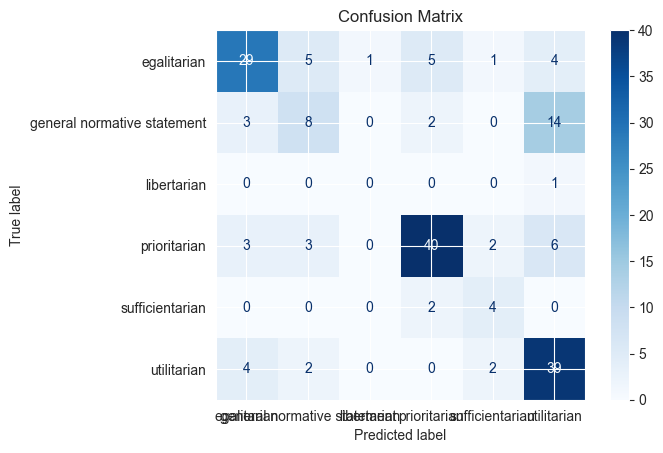

In [37]:
# Now only make confusionmatrix for one element
principle = B20_280['PRINCIPLE_x']
principle_pred = B20_280['PRINCIPLE_y']

# Step 6: Create the confusion matrix
cm = confusion_matrix(principle, principle_pred)

labels = ['egalitarian', 'general normative statement', 'libertarian', 'prioritarian', 'sufficientarian', 'utilitarian']

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [39]:
# Assuming y_true and y_pred are your true labels and predicted labels
report = classification_report(principle, principle_pred)
print(report)

                             precision    recall  f1-score   support

                egalitarian       0.74      0.64      0.69        45
general normative statement       0.44      0.30      0.36        27
                libertarian       0.00      0.00      0.00         1
               prioritarian       0.82      0.74      0.78        54
            sufficientarian       0.44      0.67      0.53         6
                utilitarian       0.61      0.83      0.70        47

                   accuracy                           0.67       180
                  macro avg       0.51      0.53      0.51       180
               weighted avg       0.67      0.67      0.66       180

